Let's import the key libraries we need and read in the data:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/holidays_events.csv')

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/train.csv', nrows=2e6)

Now, we need to filter out the data to get only Guayas region

In [7]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-7-f8cb21021b19>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time Series/Sprint 01/Lesson 04/train.csv', chunksize=chunk_size):


Let's look at the shape of the data now:

In [8]:
df_train.shape

(22941656, 6)

The dataset that we have is still very big even after filtering. To prevent our work from unexpected crashes, let's limit the dataset to include only top-3 families by number of items but first let's look at this top-3:

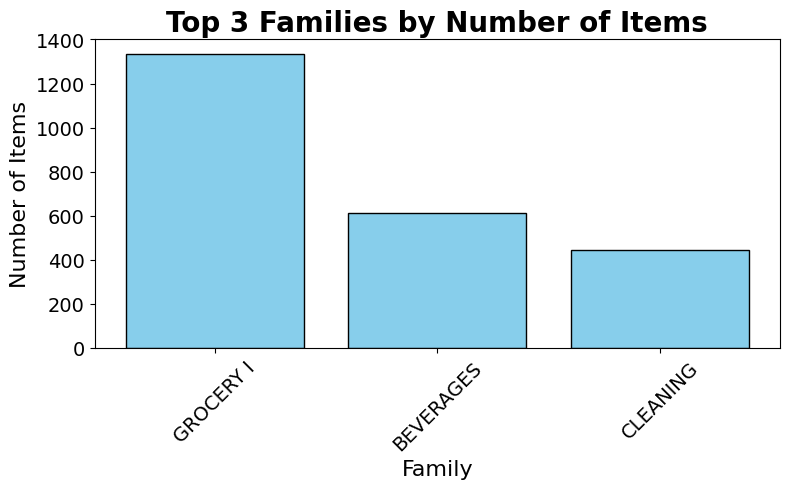

In [9]:
# Plotting the number of items per family (for top 3 families only)
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # Keep only the top 3 families

# Plot the top 3 families
plt.figure(figsize=(8, 5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'], color='skyblue', edgecolor='black')
plt.title("Top 3 Families by Number of Items", fontsize=20, fontweight='bold')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.tight_layout()
# Display the plot
plt.show()

This is how we filter our data:

In [10]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]

Let's check the shape now:

In [11]:
df_train.shape

(14745768, 6)

From around 22.9 millions of rows to around 14.7. This is our reduction.

Preprocessing:

In [12]:
# Checking missing values
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,2747275


Similar to what we saw on Campus, the onpromotion column has NaNs. Let's replace them with `False`

In [13]:
# Focusing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)

<ipython-input-13-7bdead4240c5>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool)


Outliers are next. Let's first work with the negative sales:

In [14]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

negative_sales.head()  # Viewing negative sales for analysis

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False


And now replace negative sales with 0s:

In [15]:
# Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

Next, we are going to use the function for the z-score calculation that we saw on campus:

In [16]:
# Function to calculate Z-score for each group (store-item combination)
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

Let's now apply the Z-score calculation to each store-item group but first we need to group our data by store-item. Let's do it:

In [17]:
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

<ipython-input-17-c794e573ae2a>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


Great, now we can define the threshold for the z-score and detect outliers:

In [18]:
# Define threshold for outliers (e.g., Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]
outliers

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,False,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,5.154400
...,...,...,...,...,...,...,...
14741488,114286905,2017-05-01,51,2048609,48.0,False,7.830664
14742765,104195298,2017-01-25,51,2054291,21.0,False,6.141217
14743164,122354227,2017-07-16,51,2057033,21.0,True,5.247882
14743658,117045510,2017-05-27,51,2058907,12.0,False,5.054512


There are many of these values but they don't look like errors. These are just big sales.

Next, let's work with zero-sales that we might have for particular item-store combinations and for particular dates:

In [19]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


Ok, now we have a list of all dates between the min and max date in our dataset! Next, let's create a DataFrame with all (store, item, date) combinations

In [20]:
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')
all_combinations

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


and now we are finally ready to fill up the original data with missing dates by merging two dataframes::

In [21]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,False
1,24,105574,2013-01-03,59692.0,1.0,False
2,24,105574,2013-01-04,99664.0,3.0,False
3,24,105574,2013-01-05,140805.0,4.0,False
4,24,105574,2013-01-06,182800.0,7.0,False


Now we have all dates and corresponding sales for them. Let's replace the original dataframe:

In [22]:
df_train = df_filled
del df_filled

Next, let's go and do engineering similar to what we did on Campus:

In [23]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek

In [24]:
# Calculating rolling average of unit_sales
df_train['unit_sales_7d_avg'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].transform(lambda x: x.rolling(window=7).mean())

In [25]:
df_train.head(10)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,NaN
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,NaN
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,NaN
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,NaN
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,NaN
5,24,105574,2013-01-07,223895.0,3.0,False,2013,1,7,0,NaN
6,24,105574,2013-01-08,263107.0,3.0,False,2013,1,8,1,4.714286
7,24,105574,2013-01-09,302232.0,7.0,False,2013,1,9,2,4.000000
8,24,105574,2013-01-10,341031.0,3.0,False,2013,1,10,3,4.285714
9,24,105574,2013-01-11,379570.0,6.0,False,2013,1,11,4,4.714286


Look, for the first days we have no values in the `'unit_sales_7d_avg'` column. This is because we used the window size that is equal to 7

We are all done with data preprocessing & features generation. EDA comes next! It is going to be similar to what we did on Campus for Pichincha. Let's start with total sales over time:

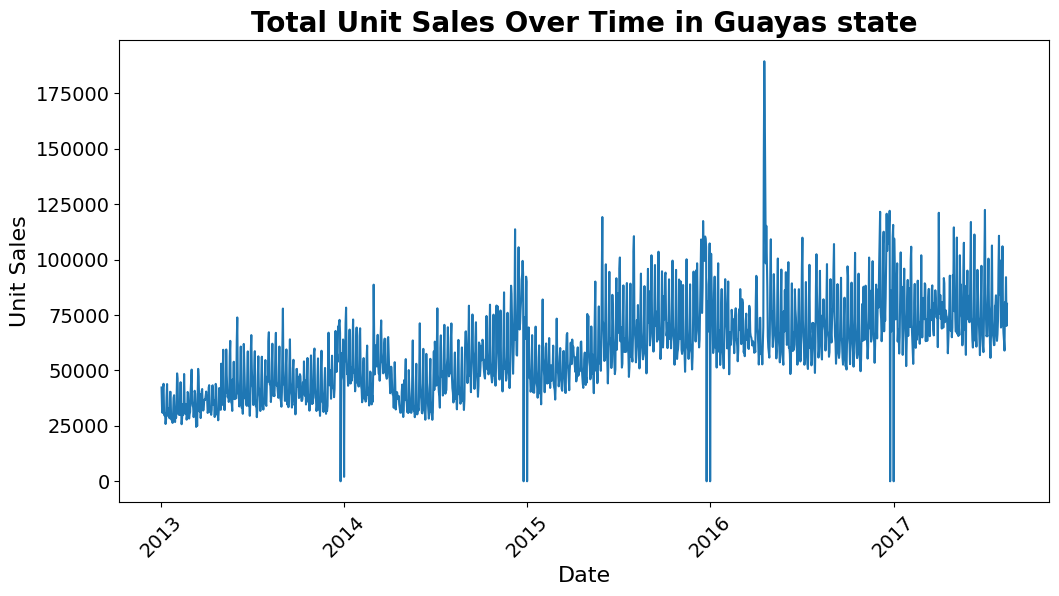

In [26]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

Next, we'll look at monthly sales:

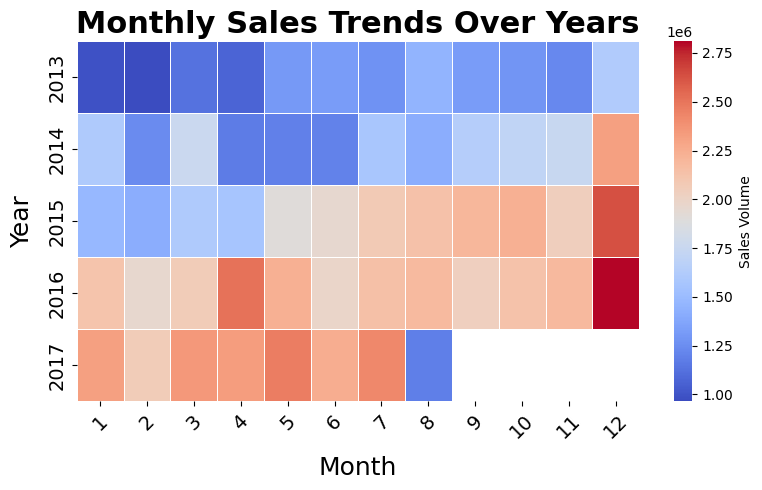

In [27]:
# Aggregating sales by year and month
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Plotting heatmap of sales by year and month
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))  # Increase figure size for better visibility
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',  # Use a diverging colormap for better contrast
    linewidths=0.5,  # Add lines between cells for clarity
    linecolor='white',  # Use white lines for a cleaner look
    cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)

# Customizing title and axes labels
plt.title('Monthly Sales Trends Over Years', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=18, labelpad=10)  # Labelpad adds spacing
plt.ylabel('Year', fontsize=18, labelpad=10)

# Formatting tick labels
plt.xticks(fontsize=14, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()

What about the impact of holidays?

In [28]:
# Convert date column to datetime
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
print("Holidays range: from",df_holidays_events['date'].dt.date.min(),"till",df_holidays_events['date'].dt.date.max())

Holidays range: from 2012-03-02 till 2017-12-26


To look at the impact of holidays, let's exclude day with zero sales like it was at the very beginning:

In [29]:
df_train_no_zero = df_train[df_train.unit_sales > 0]

In [30]:
# Merging df_train with zero sales with data with holidays
df_train_holiday = pd.merge(df_train_no_zero, df_holidays_events, on='date', how='left')

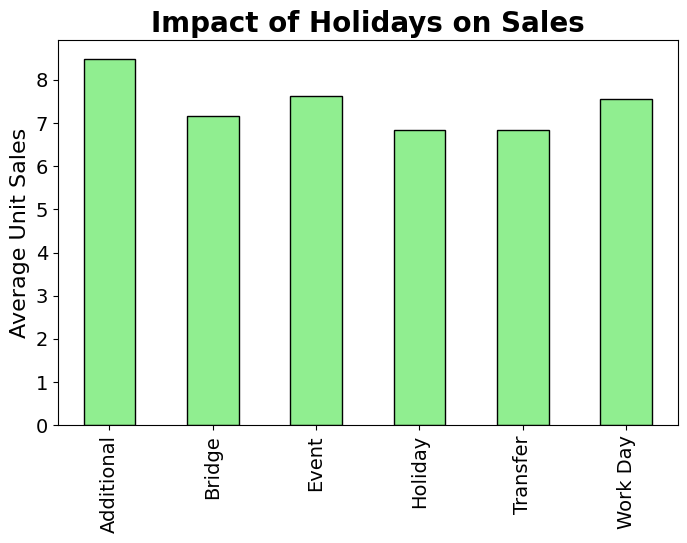

In [31]:
# Aggregating sales by holiday and non-holiday
holiday_sales = df_train_holiday.groupby('type')['unit_sales'].mean()

# Plotting holiday impact
plt.figure(figsize=(8,5))
holiday_sales.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Impact of Holidays on Sales', fontsize=20, fontweight='bold')
plt.ylabel('Average Unit Sales', fontsize=16)
plt.xlabel('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Next, please proceed further from here and do some extra EDA of your choice!

Don't forget to save your notebook and the resulting cleaned dataset to GitHub repo at the end!